# Process Normalized Cross-Study Dataset

For differential expression analysis, we processed all of the data together on a high memory node.  This was done using the minfi package in R, and all data were normalized using the preprocessQuantile function.  For a full script of the R pipeline see the [Methylation_Normalization_MINFI](./Methylation_Normalization_MINFI.ipynb) notebook.

Imports and helper functions from [Imports](Imports.ipynb) notebook.

In [1]:
cd ..

/cellar/users/agross/TCGA_Code/Methlation


In [2]:
import NotebookImport
from Setup.Imports import *
from Setup.MethylationAgeModels import *

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


importing IPython notebook from Setup/MethylationAgeModels

### Read in Validation Data

In [3]:
path = '/cellar/users/agross/TCGA_Code/Methlation/data/Validation/'

In [16]:
betas = pd.read_csv(path + 'raw_data.csv', index_col=0)

manifest1 = pd.read_csv(path + 'Sample Sheet_20151008.csv', skiprows=7)
manifest1.Sample_Name = manifest1.Sample_Name.map(lambda s: s[3:] + '_Neu')
manifest2 = pd.read_csv(path + 'Sample Sheet_20151102.csv', skiprows=7)
manifest2.Sample_Name = manifest2.Sample_Name.map(lambda s: s.strip().replace(' ','_'))
manifest = pd.concat([manifest1, manifest2])
mapping = pd.Series({'{}_{}'.format(s.Sentrix_ID, s.Sentrix_Position): s.Sample_Name
           for i,s in manifest.iterrows()})
betas = betas.rename(columns=mapping)
raw_betas = betas
raw_betas.shape

(485512, 96)

#### Looking at the quality scores on the probes

In [5]:
detection = pd.read_csv(path + 'detection_p.csv', index_col=0)
detection = detection.rename(columns=mapping)

In [6]:
dp = detection.replace(0., np.nan).stack().order()
bad_probes = (dp > .01).groupby(level=1).sum() 
bad_probes.index = bad_probes.index.map(lambda s: s.strip().replace(' ','_'))
bad_probes.order().tail()

206_Neu       272
366_Neu       281
366_CD4      1564
381_CD4     87028
352_CD4    314144
dtype: float64

In [17]:
raw_betas = raw_betas.ix[:, raw_betas.columns.difference(ti(bad_probes > 10000))]

In [9]:
from IPython.display import clear_output
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [10]:
robjects.r.library('WGCNA');
robjects.r.source("/cellar/users/agross/Data/MethylationAge/Horvath/NORMALIZATION.R")
clear_output()

In [11]:
f = '/cellar/users/agross/TCGA_Code/Methlation/data/Hannum_gold_standard.csv'
gold_standard_ah = pd.read_csv(f, index_col=0, header=None, squeeze=True)
gold_standard_ah.name = 'gs'

In [12]:
gold_standard = pd.read_csv('/cellar/users/agross/Data/MethylationAge/Horvath/probeAnnotation21kdatMethUsed.csv', index_col=0)
horvath = pd.read_table('/cellar/users/agross/TCGA_Code/Methlation/data/Horvath_Model.csv', index_col=0, skiprows=[0,1])
intercept = horvath.CoefficientTraining['(Intercept)']
horvath = horvath.iloc[1:]

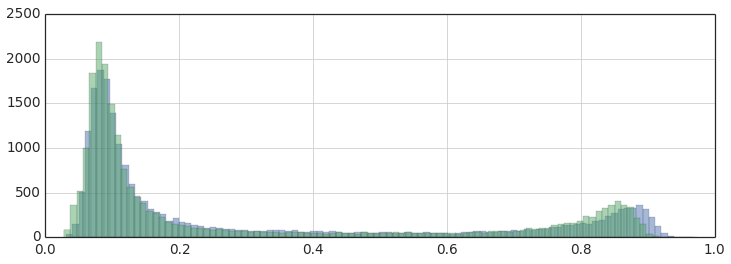

In [13]:
fig, ax = subplots(1,1, figsize=(12,4))
gold_standard_ah.ix[gold_standard.index].hist(bins=100, ax=ax, alpha=.5)
betas.ix[gold_standard.index].median(1).hist(bins=100, ax=ax, alpha=.5)

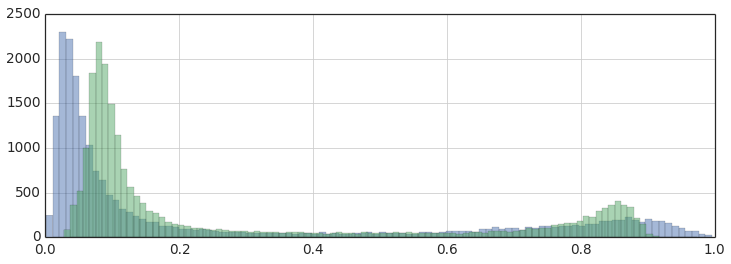

In [14]:
fig, ax = subplots(1,1, figsize=(12,4))
gold_standard.goldstandard2.hist(bins=100, ax=ax, alpha=.5)
betas.ix[gold_standard.goldstandard2.index].median(1).hist(bins=100, ax=ax, alpha=.5)

The pure cell population has a very different distribution than the reference provided by Horvath. 

In [15]:
gold_standard.goldstandard2.shape

(21368,)

In [11]:
if False:
    gs = gold_standard.goldstandard2
    gs.name = 'gs'
    df = raw_betas.ix[gs.index].dropna()
    df_r = robjects.r.t(pandas2ri.py2ri(df))
  
    gs = list(gs.ix[df.index])
    gs_r = robjects.FloatVector(gs)

    data_n = robjects.r.BMIQcalibration(df_r, gs_r)
    clear_output()

    data = pandas2ri.ri2py_dataframe(data_n).T
    data.index = data_n.colnames
    data.columns = [c.replace('X','') for c in data_n.rownames]
    data.to_csv(path + 'BMIQ_Horvath.csv')
else:
    data = pd.read_csv(path + 'BMIQ_Horvath.csv', index_col=0)
data_horvath = data

In [28]:
cell_counts = pd.read_csv(path + 'cell_counts.csv', index_col=0)
cell_counts = cell_counts.rename(index=mapping)

flow_sorted_data = pd.read_hdf('/data_ssd/methylation_annotation.h5','flow_sorted_data')
cell_type = pd.read_hdf('/data_ssd/methylation_annotation.h5', 'label_map')

n2 = flow_sorted_data.groupby(cell_type, axis=1).mean()
avg = n2[cell_counts.columns].dot(cell_counts.T)

In [29]:
cc = avg.mean(1)
adj = (data_horvath - avg).add(cc, axis=0)
adj = adj.dropna(how='all', axis=0)

data_s = adj

In [40]:
control_color = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
hiv_color = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)

def model_plot(prediction):
    fig, axs = subplots(1,3, figsize=(14,4),sharey=False)
    plot_regression(age, prediction.ix[ti(hiv=='HIV-')], ax=axs[0], 
                   color=control_color, alpha=1, edgecolor='black', s=30, 
                   line_args=[{'color':'grey','alpha':1, 'ls':'--'},
                              {'alpha':0}])
    plot_regression(age, prediction.ix[ti(hiv=='HIV+')], ax=axs[1], 
                    color=hiv_color, alpha=1, edgecolor='black', s=30, 
                    line_args=[{'color':hiv_color,'alpha':1, 'ls':'-'},
                               {'alpha':1, 'color':'grey', 'ls':'--'}])
    axs[0].set_title('HIV-')
    axs[1].set_title('HIV+')
    
    #violin_plot_pandas(hiv, prediction - age, ax=axs[2])
    #axs[2].set_ylabel('Age Advancment')
    #prettify_ax(axs[2])
    for ax in axs[[0,1]]:
        ax.set_xlim(20,75)
        ax.set_ylim(20,75)
        
    ax = axs[2]
    zscore = lambda s: (s - s.mean()) / s.std()
    residual = prediction - age
    e2 = residual.groupby(hiv).apply(zscore)
    #return residual, e2
    sns.violinplot(residual[e2.abs() < 3], hiv, ax=ax, 
                   order=['HIV-','HIV+'],
                   inner='points', inner_kws={"ms": 8}, alpha=.5,
                   bw='scott', cut=0, color=[control_color,
                                             hiv_color, hiv_color])
    x = hiv.map({'HIV-':1, 'HIV+':2})
    series_scatter(x, residual[e2.abs() > 3], color='white', edgecolor='red',
                   alpha=1, s=20, lw=1, ax=ax, ann=None)
    ax.set_ylabel('Biological Age - Chronological Age')
    ax.set_xlabel('')
    prettify_ax(ax)
    fig.tight_layout()

In [42]:
from Validation.Process_Clinical import *

In [56]:
cell_type = cell_type.ix[data_horvath.columns]

In [332]:
pred_horvath = run_horvath_model(data_s.ix[:, ti(cell_type == 'Neu')])
reg = linear_regression(age, pred_horvath.ix[ti(hiv=='HIV-')])
pred_horvath_adj = (pred_horvath - reg['intercept']) / reg['slope']

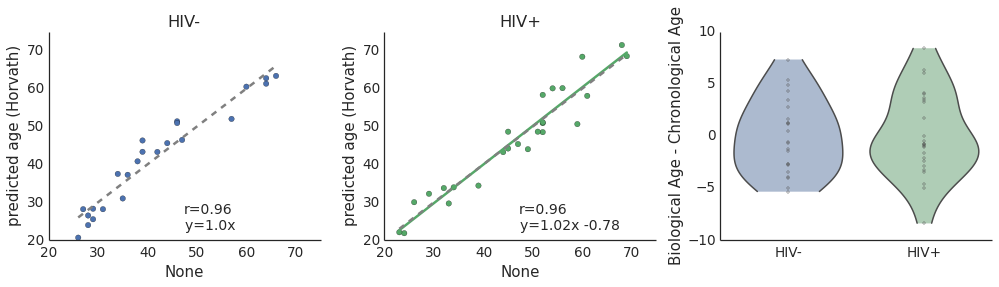

In [333]:
model_plot(pred_horvath_adj)

In [334]:
#Do not import
p4 = pred_horvath_adj 
p4.name = 'bio_age'
hiv.name = 'hiv'
df = process_factors([p4, hiv, age], standardize=False)
df.colnames = ['bio_age','hiv','age']
fmla = robjects.Formula('bio_age ~ 1 + hiv + age')
m = robjects.r.lm(fmla, df)
s = robjects.r.summary(m)
print '\n\n'.join(str(s).split('\n\n')[-3:])

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.41589    1.96239  -0.212    0.833    
hivHIV+      0.03962    1.12538   0.035    0.972    
age          1.01002    0.04317  23.397   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.831 on 45 degrees of freedom
Multiple R-squared:  0.9264,	Adjusted R-squared:  0.9231 
F-statistic: 283.1 on 2 and 45 DF,  p-value: < 2.2e-16




In [335]:
print robjects.r.confint(m)

                 2.5 %   97.5 %
(Intercept) -4.3683399 3.536563
hivHIV+     -2.2270245 2.306257
age          0.9230685 1.096964



In [316]:
pred_horvath = run_horvath_model(data_s.ix[:, ti(cell_type == 'CD4')])
reg = linear_regression(age, pred_horvath.ix[ti(hiv=='HIV-')])
pred_horvath_adj = (pred_horvath - reg['intercept']) / reg['slope']

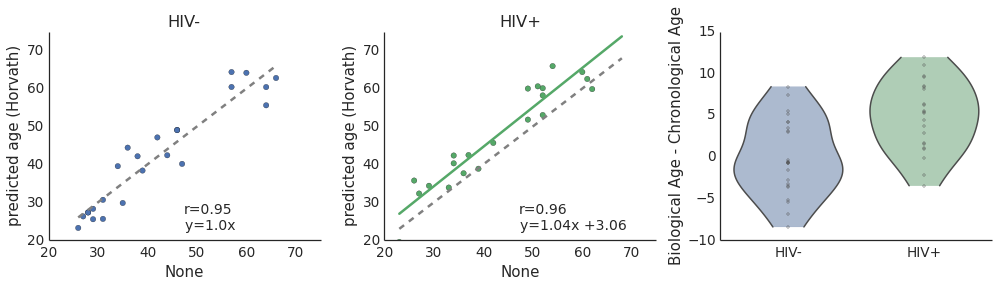

In [317]:
model_plot(pred_horvath_adj)

In [320]:
(pred_horvath_adj - age).dropna().groupby(hiv).mean()

hiv
HIV+    4.81e+00
HIV-    3.26e-15
dtype: float64

In [318]:
anova(hiv, (pred_horvath_adj - age).dropna()).ix['p'] / 2

0.00027571345113770523

In [298]:
get_error(age, pred_horvath_adj, denominator='x', groups=hiv)

,HIV+,HIV-
% error,13.14,8.80
error (years),5.34,3.69


In [68]:
path = '/cellar/users/agross/TCGA_Code/Methlation/data/Validation/'

betas = pd.read_csv(path + 'beta_qn.csv', index_col=0)
betas = betas.rename(columns=mapping)

In [69]:
cc = avg.mean(1)
adj = (betas - avg).add(cc, axis=0)
adj = adj.dropna(how='all', axis=1)

In [226]:
df = adj
df = df.ix[gold_standard_ah.index]
df = df.T.fillna(gold_standard_ah).T

In [229]:
df_cd4 = df.ix[:, ti(cell_type == 'CD4')]
df_neu = df.ix[:, ti(cell_type == 'Neu')]

In [234]:
pearson_pandas(df_cd4.mean(1), df_neu.mean(1))

rho    1
p      0
dtype: float64

In [258]:
def normalize_BMIQ(df, gs=None):
    df_r = robjects.r.t(pandas2ri.py2ri(df))
    if gs is None:
        gs = df.mean(1)
    gs = list(gs)
    gs_r = robjects.FloatVector(gs)

    data_n = robjects.r.BMIQcalibration(df_r, gs_r)
    clear_output()

    data = pandas2ri.ri2py_dataframe(data_n).T
    data.index = data_n.colnames
    data.columns = data_n.rownames
    data.columns = data.columns.str.replace('X','')
    return data

In [260]:
data_neu = normalize_BMIQ(df_neu)

In [239]:
data_cd4 = normalize_BMIQ(df_cd4)

In [266]:
df = data_neu.join(data_cd4)
df.to_csv(path + 'BMIQ_Hannum2.csv')

In [336]:
pred_hannum = run_hannum_model(data_neu.ix[:, ti(cell_type == 'Neu')])
reg = linear_regression(age, pred_hannum.ix[ti(hiv=='HIV-')].dropna())
pred_hannum_adj = (pred_hannum - reg['intercept']) / reg['slope']

In [337]:
pred_hannum_adj_n = pred_hannum_adj

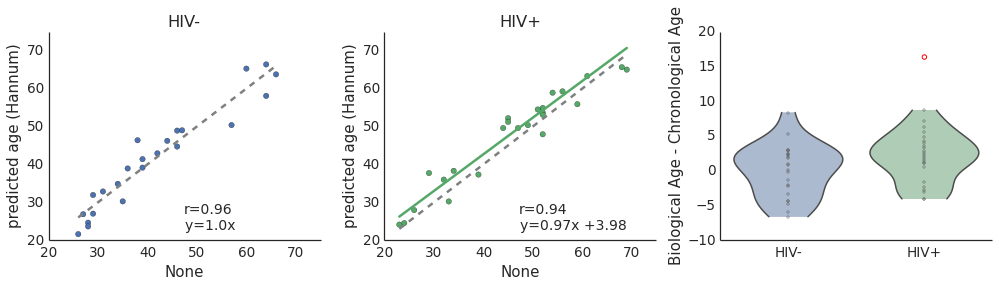

In [338]:
model_plot(pred_hannum_adj)

In [340]:
#Do not import
p4 = pred_hannum_adj 
p4.name = 'bio_age'
hiv.name = 'hiv'
df = process_factors([p4, hiv, age], standardize=False)
df.colnames = ['bio_age','hiv','age']
fmla = robjects.Formula('bio_age ~ 1 + hiv + age')
m = robjects.r.lm(fmla, df)
s = robjects.r.summary(m)
print '\n\n'.join(str(s).split('\n\n')[-3:])

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.7298     2.1502   0.339   0.7359    
hivHIV+       2.5410     1.2331   2.061   0.0451 *  
age           0.9824     0.0473  20.770   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.197 on 45 degrees of freedom
Multiple R-squared:  0.912,	Adjusted R-squared:  0.9081 
F-statistic: 233.2 on 2 and 45 DF,  p-value: < 2.2e-16




In [341]:
print robjects.r.confint(m)

                  2.5 %   97.5 %
(Intercept) -3.60085076 5.060522
hivHIV+      0.05747613 5.024576
age          0.88715463 1.077691



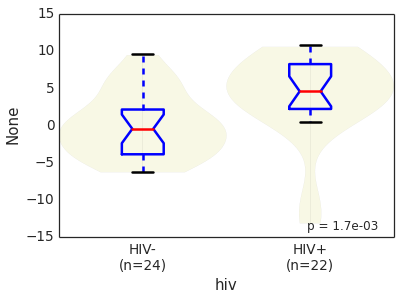

In [331]:
violin_plot_pandas(hiv, pred_hannum_adj - age)

In [264]:
(pred_hannum_adj - age).groupby(hiv).mean()

hiv
HIV+    2.46e+00
HIV-    5.56e-15
dtype: float64

In [309]:
anova(hiv, pred_hannum_adj - age).ix['p'] / 2

0.023238963548359123

In [310]:
pred_hannum = run_hannum_model(data_cd4.ix[:, ti(cell_type == 'CD4')])
reg = linear_regression(age, pred_hannum.ix[ti(hiv=='HIV-')].dropna())
pred_hannum_adj = (pred_hannum - reg['intercept']) / reg['slope']

(-10, 20)

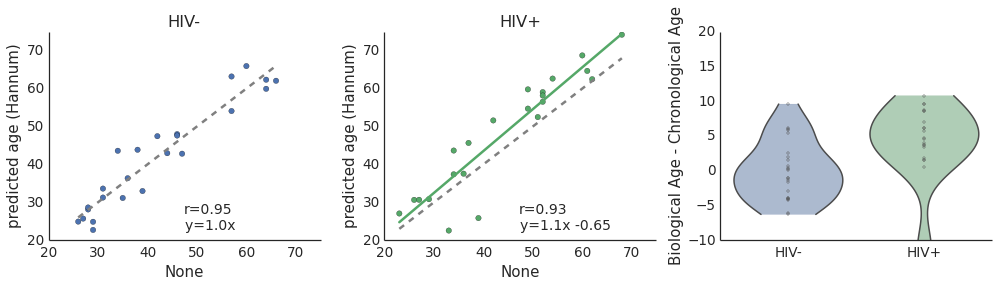

In [311]:
model_plot(pred_hannum_adj)
plt.gcf().axes[2].set_ylim(-10,20)

In [313]:
(pred_hannum_adj - age).groupby(hiv).mean()

hiv
HIV+    3.95e+00
HIV-   -7.11e-15
dtype: float64

In [312]:
anova(hiv, pred_hannum_adj - age).ix['p'] / 2

0.0060418969582970595

In [247]:
pn = pred_hannum_adj_n.copy()
pn.name = 'Neu'
pn.index = pn.index.map(lambda s: s.split('_')[0])
pt = pred_hannum_adj.copy()
pt.name = 'CD4'
pt.index = pt.index.map(lambda s: s.split('_')[0])

pa = age.copy()
pa.index = pa.index.map(lambda s: s.split('_')[0])

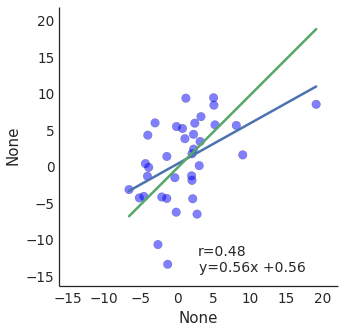

In [248]:
plot_regression(pn - pa, (pt - pa).dropna())

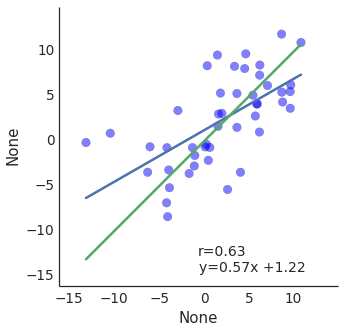

In [249]:
plot_regression((pred_hannum_adj - age), (pred_horvath_adj - age).dropna())

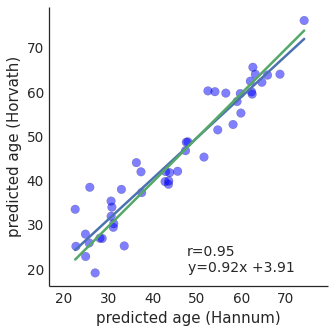

In [250]:
plot_regression(pred_hannum_adj.dropna(), pred_horvath_adj.dropna())

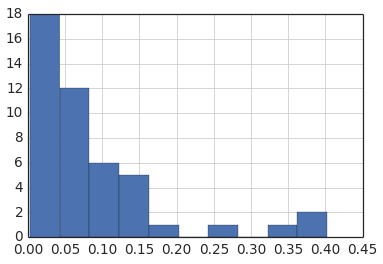

In [273]:
diff = ((pred_hannum_adj - pred_horvath_adj) / ((pred_hannum_adj + pred_horvath_adj) * .5)).abs()
diff = diff.groupby(level=0).first()
diff.name = 'Absolute difference in models'
diff.hist()

In [274]:
diff.order().tail()

218_CD4    0.20
201_CD4    0.27
369_CD4    0.32
385_CD4    0.40
366_CD4    0.40
Name: Absolute difference in models, dtype: float64

In [275]:
(pred_horvath_adj - age).groupby(hiv).mean()

hiv
HIV+    4.81e+00
HIV-    3.26e-15
dtype: float64

In [276]:
(pred_hannum_adj - age).groupby(hiv).mean()

hiv
HIV+    3.95e+00
HIV-   -7.11e-15
dtype: float64

In [277]:
pred_c = (pred_hannum_adj + pred_horvath_adj) / 2.
reg = linear_regression(age, pred_c.ix[ti(hiv=='HIV-')])
pred_c_adj = (pred_c - reg['intercept']) / reg['slope']
pred_c_adj = pred_c_adj.ix[ti(diff < .3)]

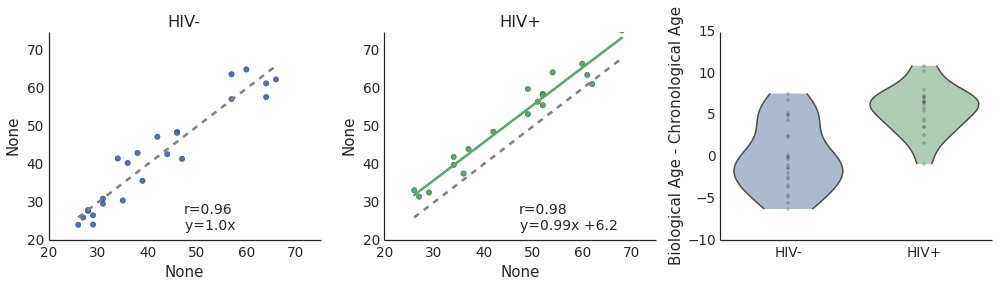

In [278]:
model_plot(pred_c_adj)

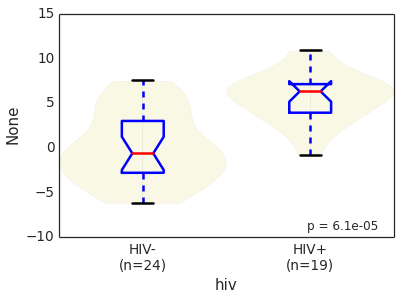

In [279]:
violin_plot_pandas(hiv, pred_c_adj - age)

In [280]:
#Do not import
p4 = pred_c.ix[pred_c_adj.index]
p4.name = 'bio_age'
hiv.name = 'hiv'
df = process_factors([p4, hiv, age], standardize=False)
df.colnames = ['bio_age','hiv','age']
fmla = robjects.Formula('bio_age ~  1 + hiv + age')
m = robjects.r.lm(fmla, df)
s = robjects.r.summary(m)
print '\n\n'.join(str(s).split('\n\n')[-3:])

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.20608    1.94852   0.106    0.916    
hivHIV+      5.68002    1.11716   5.084 9.05e-06 ***
age          0.99507    0.04316  23.055  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.589 on 40 degrees of freedom
Multiple R-squared:  0.9386,	Adjusted R-squared:  0.9356 
F-statistic: 305.9 on 2 and 40 DF,  p-value: < 2.2e-16




In [281]:
#Do not import
p4 = pred_horvath.ix[pred_c_adj.index]
p4.name = 'bio_age'
hiv.name = 'hiv'
df = process_factors([p4, hiv, age], standardize=False)
df.colnames = ['bio_age','hiv','age']
fmla = robjects.Formula('bio_age ~   1 + hiv + age')
m = robjects.r.lm(fmla, df)
s = robjects.r.summary(m)
print '\n\n'.join(str(s).split('\n\n')[-3:])

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.55471    1.91080   2.384    0.022 *  
hivHIV+      4.82536    1.09554   4.405 7.72e-05 ***
age          0.81549    0.04232  19.267  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.52 on 40 degrees of freedom
Multiple R-squared:  0.9148,	Adjusted R-squared:  0.9106 
F-statistic: 214.9 on 2 and 40 DF,  p-value: < 2.2e-16




In [324]:
#Do not import
p4 = pred_c_adj 
p4.name = 'bio_age'
hiv.name = 'hiv'
df = process_factors([p4, hiv, age], standardize=False)
df.colnames = ['bio_age','hiv','age']
fmla = robjects.Formula('bio_age ~ 1 + hiv + age')
m = robjects.r.lm(fmla, df)
s = robjects.r.summary(m)
print '\n\n'.join(str(s).split('\n\n')[-3:])

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.20608    1.94852   0.106    0.916    
hivHIV+      5.68002    1.11716   5.084 9.05e-06 ***
age          0.99507    0.04316  23.055  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.589 on 40 degrees of freedom
Multiple R-squared:  0.9386,	Adjusted R-squared:  0.9356 
F-statistic: 305.9 on 2 and 40 DF,  p-value: < 2.2e-16




One sided p-value

In [325]:
robjects.r.pt(robjects.r.coef(s)[7], s.rx('df')[0][1], lower=False)[0]

4.5233768676129315e-06

In [326]:
robjects.r.pt(robjects.r.coef(s)[5], s.rx('df')[0][1], lower=False)[0]

0.48289437675454266

In [327]:
print robjects.r.confint(m)

                 2.5 %   97.5 %
(Intercept) -3.7320304 4.144186
hivHIV+      3.4221458 7.937892
age          0.9078443 1.082303



In [286]:
(pred_c_adj - age).groupby(hiv).mean()

hiv
HIV+    5.66e+00
HIV-   -4.44e-15
dtype: float64

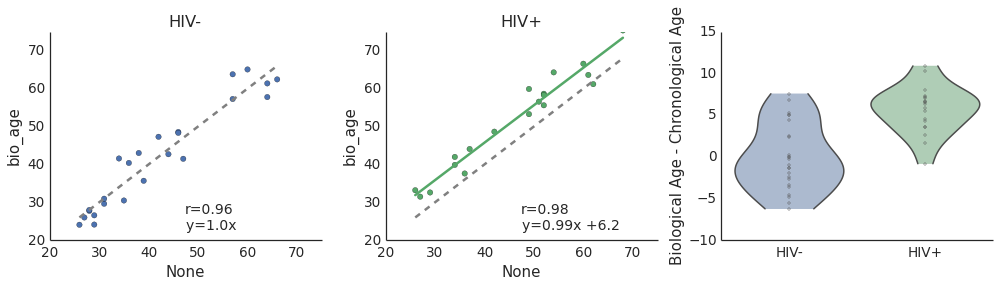

In [342]:
model_plot(pred_c_adj)